In [69]:
import tensorflow as tf
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
import seaborn as sns

In [70]:
data = pl.read_csv('SPAM text message 20170820 - Data.csv')

In [71]:
data

Category,Message
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [72]:
data.groupby('Category').count()

Category,count
str,u32
"""spam""",747
"""ham""",4825


In [73]:
ham_msg = data.filter(pl.col('Category') == 'ham')
spam_msg = data.filter(pl.col('Category') == 'spam')

In [74]:
#randomly taking data from ham_ msg
ham_msg = ham_msg.sample(n=len(spam_msg))

In [75]:
print(ham_msg.shape, spam_msg.shape)

(747, 2) (747, 2)


In [76]:
data

Category,Message
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [77]:
balanced_data = ham_msg.vstack(spam_msg)
balanced_data = balanced_data.with_columns(
    pl.when(pl.col("Category") == 'spam').then(1).otherwise(0).alias('Category')
)

In [78]:
balanced_data

Category,Message
i32,str
0,"""Or u ask they …"
0,"""Ok lar... Joki…"
0,"""I'm fine. Hope…"
0,"""In the end she…"
0,"""HARD BUT TRUE:…"
0,"""As per your re…"
0,"""MY NEW YEARS E…"
0,"""Erm. I thought…"
0,"""Honey ? Sweeth…"


In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(
    balanced_data['Message'], 
    balanced_data['Category'],
    test_size=0.2,
    random_state=42
)

In [80]:
X_train = np.array(X_train, dtype=np.chararray)
X_test = np.array(X_test, dtype=np.chararray)
X_train

array(['Good words.... But words may leave u in dismay many times.',
       'Mm yes dear look how i am hugging you both. :-P',
       'Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?',
       ...,
       'You have an important customer service announcement from PREMIER. Call FREEPHONE 0800 542 0578 now!',
       'URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED. Call 09061790126 from land line. Claim 3030. Valid 12hrs only 150ppm',
       'How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?'],
      dtype=object)

In [81]:
max_features = 5000  # Maximum vocab size.
max_len = max([len(message) for message in balanced_data['Message']])  # Sequence length to pad the outputs to.

# Create the layer.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len
)
vectorize_layer.adapt(X_test)
vectorizd_X_test = vectorize_layer(X_test)

vectorize_layer.adapt(X_train)
vectorizd_X_train = vectorize_layer(X_train)

<tf.Tensor: shape=(1195, 910), dtype=int64, numpy=
array([[  93,  942,   53, ...,    0,    0,    0],
       [1459,  156,  106, ...,    0,    0,    0],
       [ 520, 1118,   95, ...,    0,    0,    0],
       ...,
       [   4,   15,  145, ...,    0,    0,    0],
       [  74,    8,   36, ...,    0,    0,    0],
       [  95,  111,   28, ...,    0,    0,    0]])>

In [82]:
Y_train = np.array(Y_train, dtype=np.int64)
Y_test = np.array(Y_test, dtype=np.int64)

In [83]:
#model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(
            64, 
            activation='relu', 
            input_shape=(max_len,),
            kernel_regularizer=tf.keras.regularizers.L1(),
            bias_regularizer=tf.keras.regularizers.L1()
            ),
        tf.keras.layers.Dense(
            64, 
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L1(),
            bias_regularizer=tf.keras.regularizers.L1()
            ),
        tf.keras.layers.Dense(
            64, 
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L1(),
            bias_regularizer=tf.keras.regularizers.L1()
            ),
        tf.keras.layers.Dense(
            2,
            activation='softmax'
            )
    ]
)

In [84]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy()],
    optimizer = tf.keras.optimizers.Adam()
)

In [85]:
history = model.fit(
    vectorizd_X_train,
    Y_train,
    epochs=100,
)

Epoch 1/100


ValueError: in user code:

    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1085, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/metrics/accuracy_metrics.py", line 361, in accuracy  **
        y_true.shape.assert_is_compatible_with(y_pred.shape)

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [ ]:
model.evaluate(
    vectorizd_X_test,
    Y_test
)

10/10 [==============================] - 0s 5ms/step - loss: 2.1979 - accuracy: 0.0000e+00


[2.1979026794433594, 0.0]

Text(0.5, 0, 'epoch')

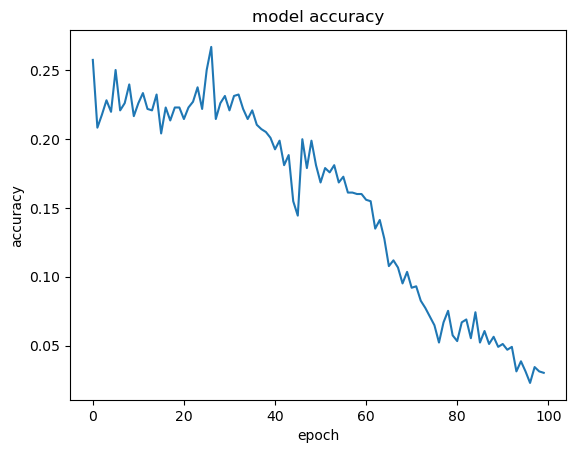

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [ ]:
predict_msg = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [ ]:
vectorize_layer.adapt(predict_msg)
vectorizd_predict_msg = vectorize_layer(predict_msg)

model.predict(vectorizd_predict_msg)

1/1 [==============================] - 0s 107ms/step


array([[0.3812535 ],
       [0.3669098 ],
       [0.39351216]], dtype=float32)